In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from joblib import Parallel, delayed
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy, LiederPolicy
from bandits import MetaBanditEnv
from evaluation import *

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

# Temporary Plots and Export Data for Plotting

In [2]:
datafile = 'data/bandit/9_10_100BO_25OBS.h5'
bo10datafile = 'data/bandit/9_10_10BO_25OBS(bo_only).h5'
dqndatafile = 'data/bandit_dqn/results/dqn_results_combined.h5'
finaldatafile = 'data/bandit/results_combined.h5'

n_arms = range(2,6)

In [3]:
#load main data
store = pd.HDFStore(datafile)
df1 = pd.concat([store['data'+str(i)] for i in n_arms])
store.close()

#load 10 BO iter data
store = pd.HDFStore(bo10datafile)
df2 = pd.concat([store['data'+str(i)] for i in n_arms])
store.close()

#load dqn data
store = pd.HDFStore(dqndatafile)
df3 = store['data']
store.close()

#fix costs of dqn
dqn_costs = df3.cost.unique()
regular_costs = df1.cost.unique()
for i in range(len(dqn_costs)):
   df3.loc[df3['cost'] == dqn_costs[i],'cost'] = regular_costs[i]
df = pd.concat([df1,df2,df3])

#save combined file
store = pd.HDFStore(finaldatafile)
store['data'] = df
store.close()

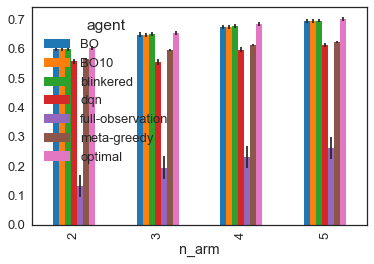

In [4]:
error_by_arm = df.groupby('n_arm agent'.split()).util.std().unstack()*1.96/np.sqrt(2000)
mean_by_arm = df.groupby('n_arm agent'.split()).util.mean().unstack()
mean_by_arm.plot(kind='bar',yerr=error_by_arm, by='cost')

In [5]:
mean_by_arm

agent,BO,BO10,blinkered,dqn,full-observation,meta-greedy,optimal
n_arm,,,,,,,
2,0.599788,0.598806,0.600328,0.556585,0.131777,0.564436,0.601904
3,0.648150,0.647949,0.649519,0.553821,0.194429,0.596537,0.654370
4,0.674501,0.673973,0.678143,0.596617,0.231100,0.613268,0.682703
5,0.693610,0.693451,0.695798,0.612441,0.259850,0.621850,0.699610


In [16]:
mean_by_arm.to_csv('data/bandit/plot/mean_by_arm')
error_by_arm.to_csv('data/bandit/plot/error_by_arm')

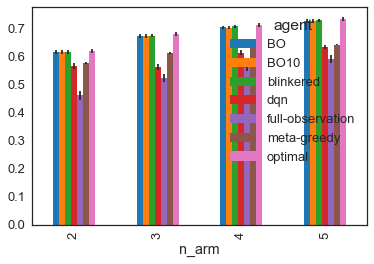

In [10]:
df2 = df[df['cost']!=0.1]
error_by_arm2 = df2.groupby('n_arm agent'.split()).util.std().unstack()*1.96/np.sqrt(2000)
mean_by_arm2 = df2.groupby('n_arm agent'.split()).util.mean().unstack()
mean_by_arm2.plot(kind='bar',yerr=error_by_arm2, by='cost')

In [12]:
mean_by_arm2.to_csv('data/bandit/plot/mean_by_arm2')
error_by_arm2.to_csv('data/bandit/plot/error_by_arm2')

(0.4, 0.8)

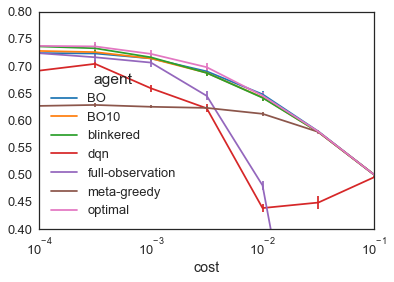

In [17]:
error_by_cost = df.groupby('cost agent'.split()).util.std().unstack()*1.96/np.sqrt(2000)
mean_by_cost = df.groupby('cost agent'.split()).util.mean().unstack()
mean_by_cost.plot(yerr=error_by_cost, logx=True, by='n_arm')
plt.ylim(0.4,0.8)

In [18]:
mean_by_cost

agent,BO,BO10,blinkered,dqn,full-observation,meta-greedy,optimal
cost,,,,,,,
0.000100,0.723667,0.727594,0.735907,0.691444,0.723447,0.626513,0.736958
0.000316,0.722955,0.725467,0.732527,0.703896,0.715979,0.628285,0.735956
0.001000,0.713864,0.713808,0.715909,0.658932,0.706216,0.624896,0.722207
0.003162,0.690062,0.687361,0.687136,0.622140,0.645001,0.622835,0.697721
0.010000,0.647907,0.642153,0.641529,0.438604,0.480316,0.611988,0.645379
0.031623,0.579629,0.578433,0.578621,0.448712,-0.067638,0.578641,0.579307
0.100000,0.500000,0.500000,0.500000,0.495333,-1.773298,0.500000,0.500000


In [19]:
mean_by_cost.to_csv('data/bandit/plot/mean_by_cost')
error_by_cost.to_csv('data/bandit/plot/error_by_cost')

# Reported Results

In [20]:
mean = mean_by_cost

In [21]:
(mean.BO10-mean.blinkered)/mean.optimal

cost
0.000100   -0.011281
0.000316   -0.009592
0.001000   -0.002909
0.003162    0.000323
0.010000    0.000966
0.031623   -0.000324
0.100000    0.000000
dtype: float64

In [22]:
(mean.BO10-mean.optimal)/mean.optimal

cost
0.000100   -0.012706
0.000316   -0.014252
0.001000   -0.011630
0.003162   -0.014848
0.010000   -0.004998
0.031623   -0.001510
0.100000    0.000000
dtype: float64

In [23]:
mean.BO10.mean()

0.6535450630519463

In [24]:
mean['full-observation'].mean()

0.20428908953600095

In [25]:
mean['meta-greedy'].mean()

0.599022625485519

In [26]:
mean['dqn'].mean()

0.579865888806257

In [23]:
mean.optimal.mean()

0.6596469105827926

In [24]:
100*mean.BO10.mean()/mean.optimal.mean()

99.07498277745964

In [25]:
mean.blinkered.mean()

0.6559469655571967

In [26]:
(mean.BO10.mean()-mean.blinkered.mean())/mean.BO10.mean()*100

-0.3675190344234145

In [28]:
(mean.BO10.mean()-mean.optimal.mean())/mean.BO10.mean()*100

-0.9336536798781244

# Export Data for ANOVA (MATLAB)

In [29]:
store = pd.HDFStore(finaldatafile)
df = store['data']
store.close()
dfs = df[['agent','n_arm','cost','util']]
dfs.agent = pd.Categorical(dfs.agent)
dfs['category'] = dfs.agent.cat.codes
dfs = dfs[['category','n_arm','cost','util']]
dfs.to_csv('dfs')

/Users/sayangul/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/sayangul/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Hypothesis driven t-tests 

## Method averaged across number of arms and costs

In [30]:
store = pd.HDFStore(finaldatafile)
df = store['data']
store.close()
df['index1'] = df.index
mean_methods = df.groupby(['index1', 'agent']).util.mean().unstack()
# mean_across = df.groupby('index agent').util.mean().unstack()
# mean_across
a = mean_methods['BO10']
other_agents =  ['blinkered','full-observation','meta-greedy','optimal','dqn']
for agent in other_agents:
    b = mean_methods[agent]
    t, p = scipy.stats.ttest_ind(a, b, equal_var=False)
    print(agent+': t = '+str(t)+'    p = '+str(p))

blinkered: t = -3.06921407231    p = 0.0021609211878
full-observation: t = 469.141045132    p = 0.0
meta-greedy: t = 83.9193015418    p = 0.0
optimal: t = -7.43442544084    p = 1.27815572879e-13
dqn: t = 79.2243708788    p = 0.0


In [31]:
a = mean_methods['blinkered']
b = mean_methods['optimal']
t,p=scipy.stats.ttest_ind(a, b, equal_var=False)
print('t = '+str(t)+'    p = '+str(p))

t = -4.8359025084    p = 1.37585292682e-06


## Method averaged across number of arms

In [32]:
store = pd.HDFStore(finaldatafile)
df = store['data']
store.close()
df['index1'] = df.index
bo_costs = df[df.agent == 'BO10'].groupby(['index1', 'cost']).util.mean().unstack()
print(bo_costs.size)
for agent in other_agents:
    print(agent)
    oa_costs = df[df.agent == agent].groupby(['index1', 'cost']).util.mean().unstack()
    for cost in bo_costs.keys():
        t, p = scipy.stats.ttest_ind(bo_costs[cost], oa_costs[cost], equal_var=False)
        print('cost = ' +str(cost)+'   t = '+str(t)+'   p = '+str(p))

14000
blinkered
cost = 0.0001   t = -3.22185652241   p = 0.00128396205094
cost = 0.000316227766017   t = -2.74271303194   p = 0.0061207046479
cost = 0.001   t = -0.858543896599   p = 0.390644309896
cost = 0.00316227766017   t = 0.10988560516   p = 0.912505641036
cost = 0.01   t = 0.288059618266   p = 0.773317170029
cost = 0.0316227766017   t = -0.15387754513   p = 0.877714058795
cost = 0.1   t = nan   p = nan
full-observation
cost = 0.0001   t = 1.47002596763   p = 0.141633835765
cost = 0.000316227766017   t = 3.44811059472   p = 0.000570369307076
cost = 0.001   t = 2.83461306345   p = 0.00461126616515
cost = 0.00316227766017   t = 16.6540667769   p = 4.36163258389e-60
cost = 0.01   t = 61.79904513   p = 0.0
cost = 0.0316227766017   t = 286.836050632   p = 0.0
cost = 0.1   t = 1165.02678334   p = 0.0
meta-greedy
cost = 0.0001   t = 49.2893679189   p = 0.0
cost = 0.000316227766017   t = 47.9982618327   p = 0.0
cost = 0.001   t = 45.2782265562   p = 0.0
cost = 0.00316227766017   t = 38.7

## Performance difference between optimal and BO (between 2 and 5 arms)

In [37]:
df[(df.agent=='optimal') & (df.cost > 0.03)]

,agent,cost,max_obs,n_arm,observations,util,index1
0,optimal,0.031623,25,2,1,0.468377,0
1,optimal,0.031623,25,2,1,0.468377,1
2,optimal,0.031623,25,2,1,0.468377,2
3,optimal,0.031623,25,2,1,0.468377,3
4,optimal,0.031623,25,2,1,0.468377,4
5,optimal,0.031623,25,2,1,0.468377,5
6,optimal,0.031623,25,2,1,0.468377,6
7,optimal,0.031623,25,2,1,0.635044,7
8,optimal,0.031623,25,2,1,0.468377,8
9,optimal,0.031623,25,2,1,0.468377,9


In [38]:
store = pd.HDFStore(finaldatafile)
df = store['data']
store.close()
df = df[df.cost!=0.1]
df['index1'] = df.index

bo_2arm = df[(df.n_arm == 2) & (df.agent=='BO10')].groupby(['index1']).util.mean()
opt_2arm = df[(df.n_arm == 2) & (df.agent=='optimal')].groupby(['index1']).util.mean()

bo_5arm = df[(df.n_arm == 5) & (df.agent=='BO10')].groupby(['index1']).util.mean()
opt_5arm = df[(df.n_arm == 5) & (df.agent=='optimal')].groupby(['index1']).util.mean()

print(bo_2arm.mean())
print(bo_5arm.mean())
print(opt_2arm.mean())
print(opt_5arm.mean())

print(bo_5arm.mean()/opt_5arm.mean())

print(bo_2arm.mean()/opt_2arm.mean())

t, p = scipy.stats.ttest_ind(bo_2arm-opt_2arm, bo_5arm-opt_5arm, equal_var=False)
print('t = ' +str(t))
print('p = ' +str(p))

0.6152739381153175
0.7256933327220975
0.6188884754877929
0.7328785496105963
0.9901958968613332
0.9941596305059219
t = 1.34151992895
p = 0.17983403675


In [39]:
for n_arm in range(2,6):
    bo_narm = df[(df.n_arm == n_arm) & (df.agent=='BO10')].groupby(['index1']).util.mean()
    opt_narm = df[(df.n_arm == n_arm) & (df.agent=='optimal')].groupby(['index1']).util.mean()
    print('n_arm = ' + str(n_arm))
    t, p = scipy.stats.ttest_ind(bo_narm, opt_narm, equal_var=False)
    print('t = ' +str(t))
    print('p = ' +str(p))

n_arm = 2
t = -1.69636857066
p = 0.0898939499804
n_arm = 3
t = -3.77651761415
p = 0.000161350283394
n_arm = 4
t = -5.66523612009
p = 1.57244356077e-08
n_arm = 5
t = -4.47780372916
p = 7.75190825164e-06


# Learning Plots

BO: [ 1.     0.412  0.412  0.177  1.   ] -> 0.694 in 146 sec
CPU times: user 4min 58s, sys: 22min 2s, total: 27min 1s
Wall time: 2min 26s


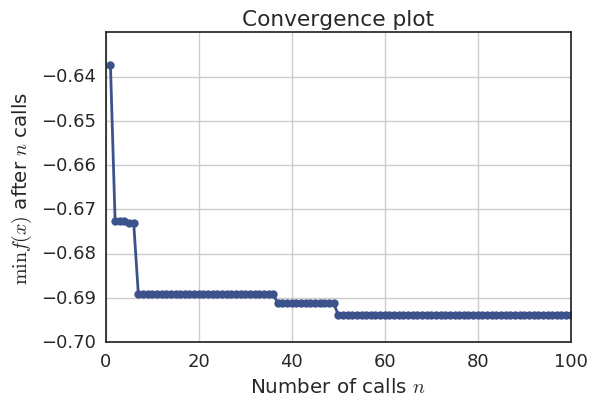

In [104]:
%%time
env = MetaBanditEnv(3, 25, np.logspace(-4,-1,7)[3])
train_envs = [env] * 1000
pol, result = bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=100, 
                        verbose=0, normalize_voi=False, return_result=True)

from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)
# plot_objective(result)

In [121]:
def learning_curve(result, n_test=2000, parallel=None):
    """Returns a learning curve for a BO result.

    BO result is output of write_bo_policy() and read_bo_result.()"""
    def loop():
        info = result.specs['info']
        test_envs = [result_env(result)] * n_test

        best_v = -np.inf
#         gp = result.models[-1]
#         pred_val = -gp.predict(result.x_iters)
        pred_val = -result.func_vals
        for v, x in zip(pred_val, result.x_iters):
            if v > best_v:
                best_v = v
                theta = x2theta(x, result.specs['info']['normalize'])
                util = get_util(LiederPolicy(theta), test_envs, parallel)
                mu, sd = util.mean(), util.std()
                print('new best {:.3f} {:.3f}'.format(best_v, mu))
                sem = sd / np.sqrt(n_test)
            yield mu
    return list(loop())

In [163]:
cost = np.logspace(-4,-1,7)[4]
cost

0.01

[ 0.576  0.627  0.5    0.5    0.626  0.5    0.666  0.626  0.627  0.575]
new best 0.576 0.574
new best 0.627 0.629
new best 0.666 0.665


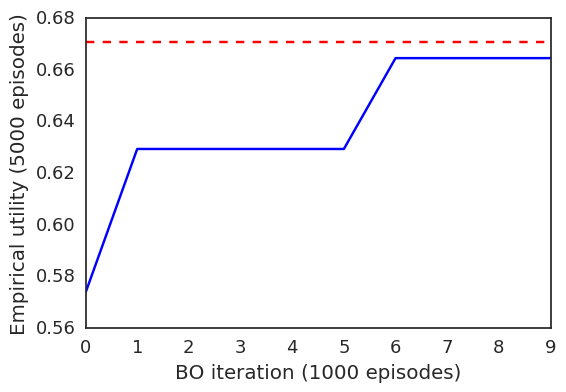

In [162]:
n_arm = 4
max_obs = 25
cost = np.logspace(-4,-1,7)[4]
result = read_bo_result(n_arm, max_obs, cost)
print(-result.func_vals)
env = result_env(result)
opt_v = df[(df.n_arm == n_arm) & (df.agent=='optimal') & (df.cost==cost)].util.mean()
best = learning_curve(result, n_test=5000)
plot_learning(best, opt_value = opt_v)